In [1]:
import os
import sys
import scipy
import pickle
import gzip
import csv 
import shutil
import subprocess

import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import multiprocessing as mp

import seaborn as sns

import statsmodels.api as sm

from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors

from collections import Counter
from collections import defaultdict


pd.options.mode.chained_assignment = None

## Access processed data

In [25]:
## Direct to path where data can be downloaded
# target_path = ""


""" Set the target directory for data access to the local objects/VISp directory from the repo """

#example:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
target_path = os.path.join(parent_dir, "objects", "VISp")

os.makedirs(target_path, exist_ok=True)



In [ ]:
"""
To install from google cloud bucket, a billing account must be set up, through the gcloud website.
Due to size limitations on github, Anndata files are too large to host on github directory and must be accessed this way.

Projection mapping dataframes for VISp are already stored in github and can be accessed without using the google bucket.

If one is unable to access the data via the google bucket, they can manually download objects from the VISp experiment anonymously from this public google drive.
https://drive.google.com/drive/u/0/folders/1U1V7Rei6ShXLDdc-2EoSN3UIrL0uW_OE

If downloading from the google drive, please place data in the ./objects/VISp folder of this repo.

"""


# Ensure gcloud sdk is installed in environment
if shutil.which("gcloud") is None:
    sys.exit("Error: gcloud CLI is not installed or not in PATH.")


files_needed = ["v1_adata.h5ad", "v1_processed_vt_df.csv", "v1_projs.pkl"]

gcloud_storage_path = "gs://macosko_public/Synapseseq_data_2025/VISp"


cp_cmds = []
for needed_file in files_needed:
    gcloud_path = os.path.join(gcloud_storage_path, needed_file)
    cmd = f"gcloud storage cp {gcloud_path} {target_path}"
    cp_cmds.append(cmd)


# execute cmds
for cp_cmd in cp_cmds:
    print(f"Executing: {cp_cmd}")
    result = subprocess.run(cp_cmd, shell=True)
    if result.returncode != 0:
        print(f"Command failed: {cp_cmd}")
        sys.exit(1)



## Load Processed Data

In [3]:
# If able to download via google cloud
v1_adata_path = os.path.join(target_path, "v1_adata.h5ad")
v1_adata = ad.read_h5ad(v1_adata_path)

In [8]:

v1_vt_df_path = os.path.join(target_path, "v1_processed_vt_df.csv")
projection_targets_path = os.path.join(target_path, "v1_projs.pkl")


v1_vt_df = pd.read_csv(v1_vt_df_path)
v1_grouped_projs = pickle.load(open(projection_targets_path, "rb"))

# snRNA-seq Clustering

In [6]:
np.random.seed(0)

v1_adata.layers["counts"] = v1_adata.X
sc.pp.normalize_total(v1_adata)
sc.pp.log1p(v1_adata)
v1_adata.layers["data"] = v1_adata.X.copy()
sc.pp.highly_variable_genes(v1_adata, n_top_genes=2000)
sc.pp.scale(v1_adata, max_value=10)
sc.tl.pca(v1_adata, n_comps=80)
sc.pp.neighbors(v1_adata, n_neighbors=10, n_pcs=80)
sc.tl.umap(v1_adata)

/home/jsilverm/mambaforge/envs/renv/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jsilverm/mambaforge/envs/renv/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/jsilverm/mambaforge/envs/renv/lib/python3.9/site-packages/umap/d

/home/jsilverm/mambaforge/envs/renv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


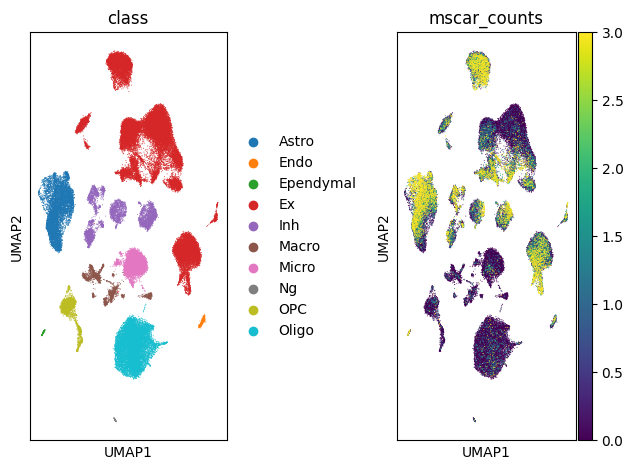

In [7]:
fig, ax = plt.subplots(ncols=2)
sc.pl.umap(v1_adata, color="class", ax=ax[0], show=False)
sc.pl.umap(v1_adata, color="mscar_counts", vmax=3, ax=ax[1], show=False)
fig.tight_layout()
fig.show()

In [68]:
oligo = ["Mobp", "St18", "Mog", "Prr5l"]
opc = ["Cspg4", "Sema3d", "Neu4", "Pdgfra"]
Ng = ["Lhx1", "Ebf3", "Eln", "Trp73"]
micro = ["Csf3r", "Tmem119", "Siglech", "Selplg"]
macro = ["Lyz2", "Ms4a6c"]
inh = ["Gad1", "Gad2", "Kcnmb2", "Alk"]
ex = ["Nrgn", "Slc17a7", "Arpp21", "Sv2b"]
Ependymal = ["Fam216b", "Unc5cl", "Ccdc153", "Tmem212"]
endo = ["Mecom", "Adgrl4", "Flt1", "Slco1a4"]
astro = ["Ntsr2", "Slc1a3", "Gli3", "Plpp3"]

markers_dict = {
    "Astro": astro, 
    "Endo": endo,
    "Ependymal": Ependymal,
    "Ex": ex,
    "Inh": inh,
    "Macro": macro,
    "Micro": micro,
    "Ng": Ng,
    "OPC": opc,
    "Oligo": oligo,
}



/home/jsilverm/mambaforge/envs/renv/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


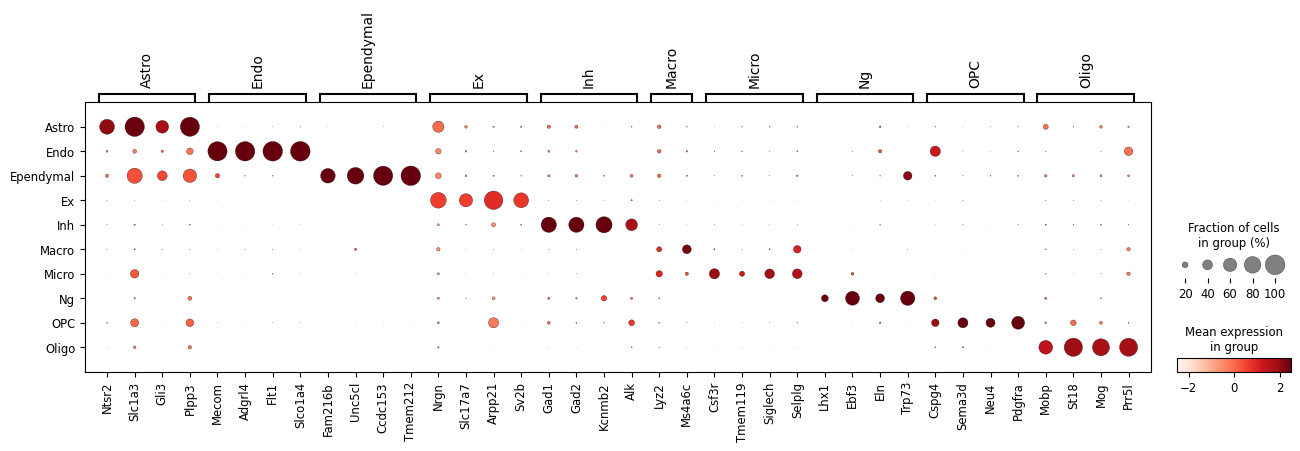

In [69]:
sc.pl.dotplot(v1_adata, var_names=markers_dict, groupby="class", vmax=2.5, vmin=-2.5)

## Subset excitatory classes

In [ ]:
prominent_cortical_subclasses = ["007_L2-3_IT_CTX_Glut", "006_L4-5_IT_CTX_Glut", "005_L5_IT_CTX_Glut", "022_L5_ET_CTX_Glut", "032_L5_NP_CTX_Glut", "030_L6_CT_CTX_Glut",  "004_L6_IT_CTX_Glut"]


In [89]:

ex_adata = v1_adata[v1_adata.obs["subclass"].isin(prominent_cortical_subclasses)]
ex_adata = ad.AnnData(ex_adata.layers["data"], obs=ex_adata.obs, var=ex_adata.var)



In [91]:
ex_adata.layers["counts"] = ex_adata.X

In [93]:
np.random.seed(0)

sc.pp.normalize_total(ex_adata)
sc.pp.log1p(ex_adata)
ex_adata.layers["data"] = ex_adata.X.copy()
sc.pp.highly_variable_genes(ex_adata, n_top_genes=2000)
sc.pp.scale(ex_adata, max_value=10)
sc.tl.pca(ex_adata, n_comps=80)
sc.pp.neighbors(ex_adata, n_neighbors=10, n_pcs=80)
sc.tl.umap(ex_adata)


/home/jsilverm/mambaforge/envs/renv/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


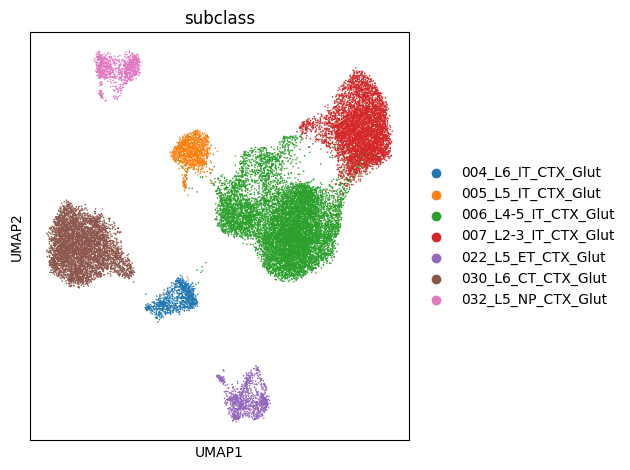

In [107]:
fig, ax = plt.subplots()
sc.pl.umap(ex_adata, color="subclass", ax=ax, show=False)
fig.tight_layout()
fig.show()

/home/jsilverm/mambaforge/envs/renv/lib/python3.9/site-packages/scanpy/plotting/_dotplot.py:749: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


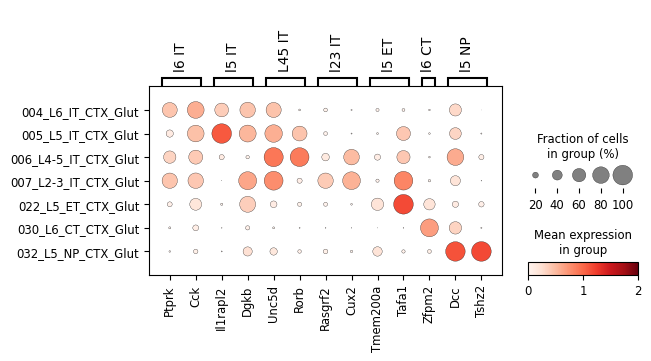

In [111]:
l6_ct = ["Zfpm2"]
l5_et = ["Tmem200a", "Tafa1"]
l5_np = ["Dcc", "Tshz2"]
l6_it = ["Ptprk", "Cck"]
l5_it = ["Il1rapl2", "Dgkb"]
L45_it = ["Unc5d", "Rorb"]
l23_it = ["Rasgrf2", "Cux2"]

ex_markers = {
    "l6 IT": l6_it,
    "l5 IT": l5_it,
    "L45 IT": L45_it,
    "l23 IT": l23_it,
    "l5 ET": l5_et,
    "l6 CT": l6_ct,
    "l5 NP": l5_np,

}

sc.pl.dotplot(ex_adata, var_names=ex_markers, groupby="subclass", vmax=2, vmin=0, layer="data")


In this experiment we targeted cell types deeper in the cortex to explicity study corticothalamic projections from L5/6.
We can observe higher average VTs/cell in cell types of deeper layers.


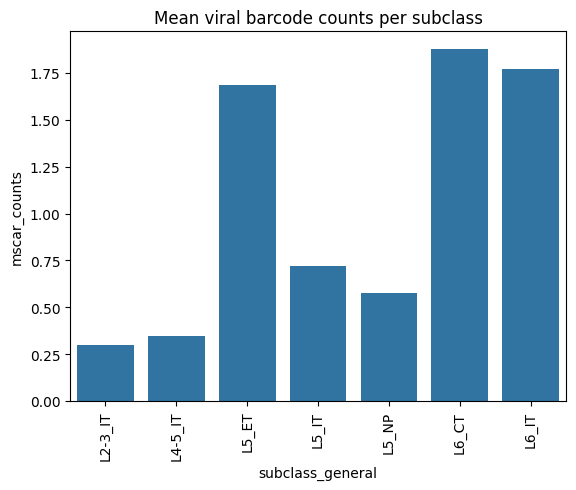

In [146]:
mean_vals = ex_adata.obs.groupby("subclass_general")["mscar_counts"].mean().reset_index()

sns.barplot(
    data=mean_vals,
    x="subclass_general",
    y="mscar_counts"
)
plt.xticks(rotation=90)
plt.title("Mean viral barcode counts per subclass")
plt.show()

# Compute mean mscar_counts per subclass_general
mean_counts = ex_adata.obs.groupby("subclass_general")["mscar_counts"].mean()

# Compute group sizes
group_sizes = ex_adata.obs["subclass_general"].value_counts()

# Combine into a single DataFrame
summary_df = pd.DataFrame({
    "mean_mscar_counts": mean_counts,
    "group_size": group_sizes
})


# Projection mapping

## Functions

In [10]:

def plot_projection_rate_normalized(vt_df, cell_type_order, ct_to_color, sig_types=[], cell_type_col="subclass", ax=None, fig=None):

    null_rate = vt_df.loc[vt_df[cell_type_col] == "Glia", "matches_thalamus"].values[0]
    vt_df["norm_proj_rate"] = vt_df["matches_thalamus"] / null_rate
    
    if ax is None or fig is None:
        fig, ax = plt.subplots()
    # Create the base plot
    sns.barplot(x=cell_type_col, y="norm_proj_rate", 
                     data=vt_df, 
                     palette=ct_to_color, 
                     order=cell_type_order,
                     ax = ax
                    )
    
    # Customize the plot
    ax.set_title('')
    ax.set_xlabel('Subclass')
    ax.set_ylabel('Normalized Thalamic Match Rate')
    # ax.set_xticks(rotation=45, ha='right')
    # ax.axhline(y=1, color="black", linestyle="--")
    # Adjust colors and add highlighting
    for i, subclass in enumerate(cell_type_order):
        bar = ax.patches[i]
        if subclass in sig_types:
            # Add red box around significant types
            fig.gca().add_patch(plt.Rectangle((bar.get_x(), bar.get_y()), 
                                              bar.get_width(), bar.get_height(), 
                                              fill=False, edgecolor='red', lw=2, linestyle='--'))
        else:
            # Lighten the color for non-significant types
            bar.set_facecolor(plt.matplotlib.colors.to_rgba(bar.get_facecolor()))

    labels = [tick.get_text() for tick in ax.get_xticklabels()]
    ax.set_xticklabels(labels, rotation=90)
    
    ax.grid(False)
def generate_color_palette(n_colors=8, palette_type="husl"):

    rgb_colors = sns.color_palette(palette_type, n_colors)
    return [mcolors.to_hex(color) for color in rgb_colors]

def display_color_palette(colors):
    """
    Display the generated color palette.
    
    Args:
    colors (list): List of color codes in hex format
    """
    plt.figure(figsize=(10, 2))
    sns.palplot(colors)
    plt.title("Generated Color Palette")
    plt.show()

from statsmodels.distributions.empirical_distribution import ECDF

def plot_truncated_ecdf(vt_rarity_dist_per_cell, ct_to_color_v1, max_val=None, ax=None, sig_types=None):
    if sig_types is None:
        sig_types =list(ct_to_color_v1.keys())
    
    if ax is None:
        fig, ax = plt.subplots()

    if max_val is None:
        max_val = 1
    for cell_type, rarity_list in vt_rarity_dist_per_cell.items():
        print(cell_type)
        if cell_type in ct_to_color_v1:
            # Truncate the data at max_val
            truncated_data = [min(x, max_val) for x in rarity_list]
            
            # Create ECDF
            ecdf = ECDF(truncated_data)
            
            # Get color for this cell type
            color = ct_to_color_v1[cell_type]
            
            # Plot ECDF
            x_values = np.sort(truncated_data)
            y_values = ecdf(x_values)

            if cell_type not in sig_types:
                color = mcolors.to_rgba(color, alpha=0.3)  
            ax.step(x_values, y_values, where='post', label=cell_type, color=color)

    ax.set_xlabel('Rarity Score')
    ax.set_ylabel('Quantile')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xlim(0, max_val)  # Set x-axis limit to max_val
    ax.set_ylim(0, 1)  # ECDF always goes from 0 to 1
    ax.grid(False)


def plot_cell_type_region_enrich(proj_parsed_obj, region, cell_types_specific=None, x_axis_grouping_tup_lis=None, title="Projection Score", ax=None):
    if cell_types_specific is None:
        cell_types_specific = list(proj_parsed_obj[list(proj_parsed_obj.keys())[0]].keys())
        cell_types_specific = [ele for ele in cell_types_specific if ele != "null"]

    if x_axis_grouping_tup_lis is not None:
        cell_type_to_group_map = {}
        for ele in x_axis_grouping_tup_lis:
            subclass = ele[0]
            for leaf in ele[1]:
                cell_type_to_group_map[leaf] = subclass
        
        subclasses_counter = defaultdict(int)
        subclass_to_leaves_map = defaultdict(list)
        for cell_type in cell_types_specific:
            subclass = cell_type_to_group_map.get(cell_type, "Other")
            subclasses_counter[subclass] += 1
            subclass_to_leaves_map[subclass].append(cell_type)
        sorted_names = sorted(subclasses_counter.keys())
        leaf_to_x_coord_map = {}
        boundary_lines = []
        label_coords = []
        labels = []
        current_x = 0
        for name in sorted_names:
            leaves = subclass_to_leaves_map[name]
            n_leaves = len(leaves)
            for i, leaf in enumerate(leaves):
                leaf_to_x_coord_map[leaf] = current_x + i
            boundary_lines.append(current_x - 0.5)
            label_coords.append(current_x + (n_leaves - 1) / 2)
            labels.append(name)
            current_x += n_leaves
        boundary_lines.append(current_x - 0.5)
    else:
        leaf_to_x_coord_map = {}
        for inx, cell_type in enumerate(cell_types_specific):
            leaf_to_x_coord_map[cell_type] = inx

    region_res = proj_parsed_obj[region]
    res_data_dict = {"cell_type": [], "mean": [], "lower_error": [], "upper_error": []}
    for cell_type in cell_types_specific:
        if cell_type not in region_res:
            continue
        ct_res = region_res[cell_type]
        means = ct_res["cell_type_means"]
        expec_mean = np.mean(means)
        lb = np.quantile(means, 0.025)
        ub = np.quantile(means, 0.975)
        low_error = expec_mean - lb
        up_error = ub - expec_mean
        res_data_dict["cell_type"].append(cell_type)
        res_data_dict["mean"].append(expec_mean)
        res_data_dict["lower_error"].append(low_error)
        res_data_dict["upper_error"].append(up_error)
    query_ct_df = pd.DataFrame(res_data_dict)
    
    null_means = region_res["null"]
    mid_null_mean = np.mean(null_means)
    lb_null = np.quantile(null_means, 0.025)
    ub_null = np.quantile(null_means, 0.975)
    
    # Create the plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 8))
    
    # Plot the null mean
    ax.axhline(y=0, color='black', linestyle='--')
    ax.axhline(y=ub_null, color='black', linestyle='--')
    
    ax.fill_between([min(leaf_to_x_coord_map.values()) - 0.5, max(leaf_to_x_coord_map.values()) + 0.5], 
                    0, ub_null, alpha=0.3, color='red', label="Glial (null) score distribution")
    
    
    error_bar_color = 'blue'
    
    for row_inx, row in query_ct_df.iterrows():
        mean = row["mean"]
        lower_error = row["lower_error"]
        upper_error = row["upper_error"]
        cell_type_name = row["cell_type"]

        x_coord = leaf_to_x_coord_map[cell_type_name]
 
        
        ax.errorbar(x_coord, mean, yerr=[[lower_error], [upper_error]], fmt='o', capsize=5, 
                    color=error_bar_color, ecolor=error_bar_color, 
                    label="Cell Type Projection Score" if row_inx == 0 else "")
    
    # Customize the plot
    ax.set_xlabel('Cell Type', fontsize=12)
    ax.set_ylabel('Group Projection Score', fontsize=12)
    # ax.set_title(title, fontsize=30)


    ax.set_xticks(list(leaf_to_x_coord_map.values()))
    ax.set_xticklabels(list(leaf_to_x_coord_map.keys()), rotation=90, ha='center', fontsize=12)

    ax.tick_params(axis='y', labelsize=16)
    
    if x_axis_grouping_tup_lis is not None:
        # Add subclass labels
        ax2 = ax.twiny()
        ax2.set_xlim(ax.get_xlim())
        ax2.set_xticks(label_coords)
        ax2.set_xticklabels(labels, rotation=90)
        ax2.grid(False)
            
    # Add vertical lines to separate subclasses
    if x_axis_grouping_tup_lis is not None:
        for line in boundary_lines:
            ax.axvline(x=line, color='gray', linestyle='--', alpha=0.5)
    
    ax.legend(fontsize=12, title_fontsize=12, loc="upper right", bbox_to_anchor=(1, 1.7))

    plt.tight_layout()
    ax.grid(False)


def preform_weighted_vt_mean_region(cell_type_scores, null_scores, cell_type, region_vts, region_name, NBOOT=1000, inx=None):

    if inx is not None:
        if inx % 100 == 0:
            print(inx)

    n_vts_ct_total = len(cell_type_scores)
    n_vts_proj_region = np.sum(cell_type_scores > 0)
    
    
    ct_compare_weighted_mean = np.mean(cell_type_scores)
    n_vts_compare = len(cell_type_scores)
    
    null_weighted_means = bootstrap_null_weighted_mean(null_scores,n_vts_compare, NBOOT=NBOOT)
    std_null_weighted_means = np.std(null_weighted_means)
    mean_null_weighted_means = np.mean(null_weighted_means)
    
    p_val = np.mean(null_weighted_means >= ct_compare_weighted_mean)

    if std_null_weighted_means == 0:
        std_null_weighted_means = 0.00001
    z_score = (ct_compare_weighted_mean - mean_null_weighted_means) / std_null_weighted_means

    res = {"cell_type": cell_type, 
           "region": region_name,
           "p_val": p_val,
           "z_score": z_score,
           "ct_weighted_mean":ct_compare_weighted_mean,
           "std_null_weighted_means": std_null_weighted_means,
           "mean_null_weighted_means": mean_null_weighted_means,
           "n_vts_proj_region": n_vts_proj_region,
           "n_vts_ct_total": n_vts_ct_total
          }
    return res


# def preform_weighted_vt_mean_region_w_jackknife(cell_type_scores, null_scores, cell_type_compare, region_vts, region_name, jackknife_holdout_prop = 0.2, jackknife_holdout_n = 1, n_jackknives=1000, inx=None):

def preform_weighted_vt_mean_region_w_jackknife(jackknife_args):
    cell_type_scores = jackknife_args["cell_type_scores"]
    null_scores = jackknife_args["null_scores"]
    cell_type = jackknife_args["cell_type"]
    region_vts = jackknife_args["region_vts"]
    region_name = jackknife_args["region_name"]
    jackknife_holdout_prop = jackknife_args.get("jackknife_holdout_prop", None)
    jackknife_n_holdout = jackknife_args.get("jackknife_n_holdout", None)
    n_jackknives = jackknife_args.get("n_jackknives", 1000)
    NBOOT = jackknife_args.get("NBOOT", 1000)
    inx = jackknife_args.get("inx", None)


    if (jackknife_holdout_prop is None)  and (jackknife_n_holdout is None):
        raise Exception("Must provide proprtion or N to holdout")

    if (jackknife_holdout_prop is not None)  and (jackknife_n_holdout is not None):
        raise Exception("Both n and proportion provided. Must leave one None")
    
    if inx is not None:
        if inx % 100 == 0:
            print(inx)

    n_vts_ct_total = len(cell_type_scores)
    n_vts_proj_region = np.sum(cell_type_scores > 0)

    if jackknife_holdout_prop is not None:

        ct_jackknifing_prop = 1-jackknife_holdout_prop
        n_vts_jackknifing = int(np.ceil(len(cell_type_scores) * ct_jackknifing_prop))
    elif jackknife_n_holdout is not None:
        n_vts_jackknifing = len(cell_type_scores) - jackknife_n_holdout


    if (jackknife_n_holdout is None) or jackknife_n_holdout > 1:
        jackknifed_means = []
        for _ in range(n_jackknives):
            cell_type_scores_sampled = np.random.choice(cell_type_scores, n_vts_jackknifing, replace=True)
            c_mean = np.mean(cell_type_scores_sampled)
            jackknifed_means.append(c_mean)
    else:
        # preforming hold out each single vt
        n_jackknives = len(cell_type_scores)
        jackknifed_means = []
        for inx in range(n_jackknives):
            cell_type_scores_one_removed = np.delete(cell_type_scores, inx)
            c_mean = np.mean(cell_type_scores_one_removed)
            jackknifed_means.append(c_mean)
    
    null_weighted_means = bootstrap_null_weighted_mean(null_scores,n_vts_jackknifing, NBOOT=NBOOT)
    std_null_weighted_means = np.std(null_weighted_means)
    mean_null_weighted_means = np.mean(null_weighted_means)
    
    if std_null_weighted_means == 0:
        std_null_weighted_means = 0.00001
        
    jackknife_p_vals = []
    jackknife_z_scores = []
    for inx in range(n_jackknives):
        c_mean = jackknifed_means[inx]
        p_val = np.mean(null_weighted_means >= c_mean)
        z_score = (c_mean - mean_null_weighted_means) / std_null_weighted_means
        jackknife_p_vals.append(p_val)
        jackknife_z_scores.append(z_score)

    zscore_mean = np.mean(jackknife_z_scores)
    
    res = {"cell_type": cell_type, 
           "region": region_name,
           "jackknife_p_vals": jackknife_p_vals,
           "jackknife_z_scores": jackknife_z_scores,
           "zscore_mean": zscore_mean,
           "std_null_weighted_means": std_null_weighted_means,
           "mean_null_weighted_means": mean_null_weighted_means,
           "n_vts_proj_region": n_vts_proj_region,
           "n_vts_ct_total": n_vts_ct_total,
           "jackknifed_means": jackknifed_means,
           "null_weighted_means": null_weighted_means
          }
    return res

def bootstrap_null_weighted_mean(null_scores, n_vts_compare, NBOOT=1000):
    weighted_means = []
    # return cdf_ct
    for inx in range(NBOOT):
        sampling = np.random.choice(null_scores, n_vts_compare, replace=True)
        weighted_mean = np.mean(sampling)
        weighted_means.append(weighted_mean)
    return np.array(weighted_means)


def parse_unordered_weighted_mean_results(unordered_results):
    df_dict = {"cell_type": [], "region": [], "p_val": [], "z_score": [], "n_vts_proj_region": [], "n_vts_ct_total": []}
    for ele in unordered_results:
        df_dict["cell_type"].append(ele["cell_type"])
        df_dict["region"].append(ele["region"])
        df_dict["p_val"].append(ele["p_val"])
        df_dict["z_score"].append(ele["z_score"])
        df_dict["n_vts_proj_region"].append(ele["n_vts_proj_region"])
        df_dict["n_vts_ct_total"].append(ele["n_vts_ct_total"])

    df_res = pd.DataFrame(df_dict)
    df_res["prop_vts"] = df_res["n_vts_proj_region"] / df_res["n_vts_ct_total"]
    return df_res

def preform_all_celltype_region_comparisons(cell_vt_df, proj_dict, score_col, cell_type_col = "pknn_subclass_pred", null_type="Glia", NBOOT=1000, min_ct_n = 20):

    cell_vt_df = cell_vt_df[cell_vt_df["is_mscar"]]
    
    unique_regions = list(proj_dict.keys())

    cell_type_counts = cell_vt_df[cell_type_col].value_counts()
    valid_cts = cell_type_counts[cell_type_counts >= min_ct_n].index

    args = []
    arg_inx = 0
    for region in unique_regions:
        region_vts = proj_dict[region]
        cell_vt_df_region = cell_vt_df.copy()
        projects_region = cell_vt_df_region["vt"].isin(region_vts)
        cell_vt_df_region["region_score"] = cell_vt_df_region[score_col]
        cell_vt_df_region.loc[~projects_region, "region_score"] = 0

        
        cell_type_to_vt_scores = cell_vt_df_region.groupby(cell_type_col)["region_score"].apply(list).to_dict()
        null_scores = cell_type_to_vt_scores.pop(null_type)

        for cell_type in valid_cts:
            if cell_type == null_type:
                continue
            cell_type_scores = np.array(cell_type_to_vt_scores[cell_type])

            c_args = (cell_type_scores, null_scores, cell_type, region_vts, region, NBOOT, arg_inx)
            args.append(c_args)
            arg_inx+=1

    print(len(args))
    # results = [preform_weighted_vt_mean_region(*arg_e) for arg_e in args]
    n_cores = 30
    pool = mp.Pool(n_cores)
    results = pool.starmap(preform_weighted_vt_mean_region, args)
    pool.close()
    pool.join()

    parsed_df = parse_unordered_weighted_mean_results(results)
    
    return parsed_df

def parse_jackknife_results(jackknife_results_lis):
    print("Parsing jacknife results")
    df_dict = {"cell_type": [], "region": [], "jack_p_val": [], "jack_z_score": [], "n_vts_proj_region": [], "n_vts_ct_total": []}
    n_total_eles = len(jackknife_results_lis)
    for ele_inx, ele in enumerate(jackknife_results_lis):

        if ele_inx % 100 == 0:
            print(round(ele_inx / n_total_eles, 3))

        p_vals = ele["jackknife_p_vals"]
        z_scores = ele["jackknife_z_scores"]

        jack_p_val = np.mean(p_vals)
        jack_z_score = np.mean(z_scores)
        
        df_dict["cell_type"].append(ele["cell_type"])
        df_dict["region"].append(ele["region"])
        df_dict["jack_p_val"].append(jack_p_val)
        df_dict["jack_z_score"].append(jack_z_score)
        df_dict["n_vts_proj_region"].append(ele["n_vts_proj_region"])
        df_dict["n_vts_ct_total"].append(ele["n_vts_ct_total"])

    df_res = pd.DataFrame(df_dict)
    df_res["prop_vts"] = df_res["n_vts_proj_region"] / df_res["n_vts_ct_total"]
    return df_res


def preform_all_celltype_region_comparisons_jackknife(cell_vt_df, proj_dict, score_col, cell_type_col = "pknn_subclass_pred", null_type="Glia", jackknife_holdout_prop=None, jackknife_n_holdout=None, n_jackknives = 1000, min_ct_n = 20, NBOOT=1000, return_unparsed=False):

    np.random.seed(10)
    
    if (jackknife_holdout_prop is None)  and (jackknife_n_holdout is None):
        raise Exception("Must provide proprtion or N to holdout")

    if (jackknife_holdout_prop is not None)  and (jackknife_n_holdout is not None):
        raise Exception("Both n and proportion provided. Must leave one None")
    
    cell_vt_df = cell_vt_df[cell_vt_df["is_mscar"]]
    
    unique_regions = list(proj_dict.keys())

    cell_type_counts = cell_vt_df[cell_type_col].value_counts()
    valid_cts = cell_type_counts[cell_type_counts >= min_ct_n].index

    args = []
    arg_inx = 0
    total_regions = len(unique_regions)
    for region_inx, region in enumerate(unique_regions):

        if region_inx % 100 == 0:
            print(round(region_inx / total_regions, 3))
        
        region_vts = proj_dict[region]
        cell_vt_df_region = cell_vt_df.copy()
        projects_region = cell_vt_df_region["vt"].isin(region_vts)
        cell_vt_df_region["region_score"] = cell_vt_df_region[score_col]
        cell_vt_df_region.loc[~projects_region, "region_score"] = 0

        cell_type_to_vt_scores = cell_vt_df_region.groupby(cell_type_col)["region_score"].apply(list).to_dict()
        null_scores = cell_type_to_vt_scores.pop(null_type)

        for cell_type in valid_cts:
            if cell_type == null_type:
                continue
            cell_type_scores = np.array(cell_type_to_vt_scores[cell_type])
            jackargs_dict = {"cell_type_scores":cell_type_scores,
                            "null_scores":null_scores,
                             "cell_type": cell_type,
                             "region_vts": region_vts,
                             "region_name": region,
                             "jackknife_holdout_prop": jackknife_holdout_prop,
                             "n_jackknives":n_jackknives,
                             "jackknife_n_holdout": jackknife_n_holdout,
                             "inx": arg_inx,
                             "NBOOT": NBOOT
                            }
            c_args = (jackargs_dict,)
            # c_args = (cell_type_scores, null_scores, cell_type, region_vts, region, jackknife_holdout_prop, n_jackknives, arg_inx)
            args.append(c_args)
            arg_inx+=1

    print(len(args))

    n_cores = 30
    pool = mp.Pool(n_cores)
    results = pool.starmap(preform_weighted_vt_mean_region_w_jackknife, args)
    pool.close()
    pool.join()

    if return_unparsed:
        return results
    
    jack_df = parse_jackknife_results(results)
    
    return jack_df


def parse_cell_type_proj_dists(proj_dists_obj):
    dict_res  = defaultdict(dict)
    for ele in proj_dists_obj:
        cell_type = ele["cell_type"]
        region = ele["region"]
        jack_p_val = ele["jackknife_p_vals"]
        jack_means  = ele["jackknifed_means"]

        current_null_means = dict_res[region].get("null", None)
        if current_null_means is None:
            null_means  = ele["null_weighted_means"]
            dict_res[region]["null"] = null_means
    
        jack_p = np.mean(jack_p_val)
        dict_res[region][cell_type] = {"p": jack_p, "cell_type_means": jack_means}
    return dict_res


def create_basic_dotplot_proj_sub_groupings_continous(proj_df, cell_type_col, region_col, value_col, color_col, text_col,
                                 x_axis_grouping_tup_list = None, last_ordering=["empty"], title="CT Projections",
                                 cell_type_ordering=None, region_ordering=None ,
                                 show_intersections_by_ct = True, color_scale_min=-3, color_scale_max=None, 
                                sig_val=0.05, min_show_val=0.2, size_scale=1, alt_size=10, negate_sig_val=False,
                                 only_show_text_if_sig=False, pdf=None, only_show_projecting_cts=True, show_text=True, 
                                                      vmax=0.1, vmin=0, xtick_fsize=12, ytick_fsize=12,min_n_red_circle=0,
                                                      save_path=None, space_per_ct=1, space_per_region=1, show_p_val_legend=True,
                                                      keep_types=None, sizing_factor_x=0, sizing_factor_y=0, cell_match_rates_dict=None,
                                                      sig_circle_width=1.5, total_intersects_by_ct={}
                                                     ):

    # Set sizing function for dots on the plot
    # sizing_func = lambda x: 1000 * np.log10((1/x))
    # sizing_func = lambda x: x * 400 if x > 2 else 10

    def sizing_func(p_val, show_p_val=0.35, max_p=0, scale=size_scale, min_size=alt_size, alt_size=alt_size):
        ref_p_sizes = {0: 1000, 0.001: 500, 0.01: 250, 0.1: 125, 0.2: 30, 0.3: 15, 0.5: 5}
        ref_p_sizes_scaled = {p: size*scale for p, size in ref_p_sizes.items()}
        max_size = ref_p_sizes_scaled[0]
        if p_val >= show_p_val:
            # return min_size
            return 0
        
        sorted_p_vals = sorted(ref_p_sizes_scaled.keys())
        
        for i in range(len(sorted_p_vals) - 1):
            lower_p = sorted_p_vals[i]
            upper_p = sorted_p_vals[i + 1]
            
            if lower_p <= p_val < upper_p:
                lower_size = ref_p_sizes_scaled[lower_p]
                upper_size = ref_p_sizes_scaled[upper_p]
                
                # Linear interpolation
                slope = (upper_size - lower_size) / (upper_p - lower_p)
                interpolated_size = lower_size + slope * (p_val - lower_p)
                
                return max(min_size, min(max_size, interpolated_size))
        
        # If p_val is smaller than the smallest reference p-value
        return max_size

    def color_func(prop_val, vmax=0.1, vmin=0):
        # Create a Normalize object
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
        
        # Normalize the value
        normalized_val = norm(prop_val)
        
        # Create a color map (blues)
        cmap = mcolors.LinearSegmentedColormap.from_list("", ["#d0d0d0", "#1e3a8a"])
        
        # Get the RGB color
        rgb_color = cmap(normalized_val)
        
        # Convert RGB to hex
        hex_color = mcolors.rgb2hex(rgb_color)
        
        return hex_color

    if only_show_projecting_cts:

        proj_df = subset_to_proj_cts(proj_df, sig_val=min_show_val, keep_types=keep_types)

    # Create a figure and axis
    # fig, ax = plt.subplots(figsize=(20, 10))
    n_cts = proj_df[cell_type_col].nunique()
    n_regions = proj_df[region_col].nunique()
    width = n_cts * space_per_ct
    height = n_regions * space_per_region
    plt.figure(dpi=400)
    fig, ax = plt.subplots(figsize=(width, height))
    unique_col_present  = proj_df[cell_type_col].unique()

    #### Setting cell type grouping info ####
    if x_axis_grouping_tup_list is not None:
        
        order_x_alphabetically=False

        x_labels_list = []
        break_points = []
        current_x_inx = 0

        all_leaves_in_group = set([ele for tup in x_axis_grouping_tup_list for ele in tup[1]])
        unique_cols_not_in_group = [ele for ele in unique_col_present if ele not in all_leaves_in_group]
        unknown_tup = ("unknown", unique_cols_not_in_group)
        # add to front
        x_axis_grouping_tup_list = [unknown_tup] + x_axis_grouping_tup_list
        # loop through the groups and add the leafs in that group to the xlabels if they are present
        for group, leaf_list in x_axis_grouping_tup_list:
            current_group_leaf_list = []
            for leaf_name in leaf_list:
    
                if leaf_name not in unique_col_present:
                    continue

                current_group_leaf_list.append(leaf_name)
            if len(current_group_leaf_list) == 0:
                continue

            x_labels_list.extend(current_group_leaf_list)
            current_break_point_ele = {"name": group, "start": current_x_inx}
            current_x_inx += len(current_group_leaf_list)
            current_break_point_ele["end"] = current_x_inx
            break_points.append(current_break_point_ele)
        unique_cell_types = np.array(x_labels_list)
    else:
        if cell_type_ordering is None:
            # reorder xlabels such that glia and empties are last
            xlabels = [ele for ele in unique_col_present if ele not in last_ordering]
            last_ordering_present_in_data = [ele for ele in last_ordering if ele in unique_col_present]
            xlabels.extend(last_ordering_present_in_data)
            unique_cell_types = np.array(xlabels)
        else:
            unique_cell_types = np.array(cell_type_ordering)              


    if region_ordering is None:
        unique_regions = proj_df[region_col].unique()
        unique_regions = np.sort(unique_regions)
    else:
        unique_regions = np.array(region_ordering)
    n_regions = len(unique_regions)
    #### Loop for placing dots ####
    for index, row in proj_df.iterrows():
        # Get the x and y values
        cell_type = row[cell_type_col]
        region = row[region_col]

        if cell_type not in unique_cell_types:
            continue

        row_inx = np.where(unique_regions == region)[0][0]
        col_inx = np.where(unique_cell_types == cell_type)[0][0]

        # Determine if the point is significant
        current_value = round(row[value_col], 4)
        n_projs_region = row["n_vts_proj_region"]
        if negate_sig_val:
            is_sig = (current_value <= sig_val) & (n_projs_region >= min_n_red_circle)
        else:
            is_sig = current_value >= sig_val & (n_projs_region >= min_n_red_circle)
        pt_size = sizing_func(current_value)

        # Plot the point
        if cell_match_rates_dict is not None:
            color = cell_match_rates_dict[region][cell_type]
        else:
            color=row[color_col]
        current_color_val = color_func(color, vmax=vmax, vmin=vmin)

        ax.scatter(col_inx, row_inx, c=current_color_val, s = pt_size, cmap="Blues", vmin=color_scale_min, vmax=color_scale_max)

        # Add a red circle if the point is significant
        if is_sig:
            ax.scatter(col_inx, row_inx, s=pt_size, facecolors='none', edgecolors='red', linewidths=sig_circle_width)
        text_val = round(row[text_col], 3)
        if (show_text and (is_sig or (not only_show_text_if_sig))):
            ax.text(col_inx, row_inx, f"{text_val}", ha='center', va='center', weight="bold")

    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)    
    # Create a color map (blues)
    cmap = mcolors.LinearSegmentedColormap.from_list("", ["#d0d0d0", "#1e3a8a"])
    # Create a ScalarMappable object
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # This line is necessary for the colorbar to work correctly

    # Add the colorbar
    cbar = fig.colorbar(sm, ax=ax)
    cbar.ax.tick_params(labelsize=10)
    cbar.set_label("Proportion of cells matching", fontsize=12, rotation=270, labelpad=14)
                                                         
            
    ymin, ymax = ax.get_ylim()
    # Display sum_intersection_by_ct values at the top of each column
    if show_intersections_by_ct:

        for col_inx, cell_type in enumerate(unique_cell_types):
            # if cell_type in total_intersects_by_ct:
            value = total_intersects_by_ct.get(cell_type, 0)
                
            ax.text(col_inx, n_regions-0.3, f"{value}", ha='center', va='top', rotation=90, weight="bold")

    # Add lines denoting the groupings of differnt sub cell types
    if x_axis_grouping_tup_list is not None:
        for break_point in break_points:
            ax.axvline(break_point["end"] - 0.5, color="black")
            if show_text:
                mid_point = ((break_point["start"] + break_point["end"]) / 2) - 1
                # move cell type grouping text down 50 units
                ax.text(mid_point, ymax, break_point["name"], rotation=90, weight="bold")


    ax.set_xticks(np.arange(len(unique_cell_types)))
    ax.set_xticklabels(unique_cell_types, rotation=90, fontsize=xtick_fsize)
    ax.set_yticks(np.arange(len(unique_regions)))
    ax.set_yticklabels(unique_regions, fontsize=ytick_fsize)
    ax.grid(False)
    # title_y=1

    if title == "":
        title = "P-value"

    # Get the current limits
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
    
    # Expand the limits by a certain factor (e.g., 10%)
    # expand_factor = -0.04
    x_range = x_max - x_min
    y_range = y_max - y_min
    
    ax.set_xlim(x_min - sizing_factor_x * x_range, x_max + sizing_factor_x * x_range)
    ax.set_ylim(y_min - sizing_factor_y * y_range, y_max + sizing_factor_y * y_range)

    # if show_intersections_by_ct:
    title_y = 1.35
                                                         
    p_vals_legend_pos = 1.3

    if show_p_val_legend:
        size_legend = [0, 0.001, 0.01, 0.05, 0.1, 0.2]
        size_legend_sizes = [sizing_func(i) for i in size_legend]
        size_legend_labels = [f'{i}' for i in size_legend]
        handles = [plt.scatter([], [], color='grey', s=size) for size in size_legend_sizes]
        size_legend = ax.legend(handles, size_legend_labels, title='', loc="upper center", 
                                ncol=len(size_legend), handletextpad=1.5, bbox_to_anchor=(0.5, p_vals_legend_pos))
        size_legend.set_frame_on(False)

    ax.set_title(title, y=title_y, fontdict={"fontsize":12})
                                                         
    # Adjust the layout to make room for the legend
    plt.tight_layout()
    # plt.subplots_adjust(top
    if save_path is not None:
        fig.savefig(save_path, transparent=True)
    
    fig.show()

def compute_cell_to_region_match_df(cell_vt_df, proj_dict, cell_type_col="subclass_visual"):
    cell_region_projs = {"cell_id": [], "cell_type": [], "region": []}
    for region, vts in proj_dict.items():
            
        cell_vt_df["proj_region"] = cell_vt_df["vt"].isin(vts)
        cell_vt_proj_df = cell_vt_df.loc[cell_vt_df["proj_region"]]
        for inx, row in cell_vt_proj_df.iterrows():
            cell_region_projs["cell_id"].append(row['cell'])
            cell_region_projs["cell_type"].append(row[cell_type_col])
            cell_region_projs["region"].append(region)
    cell_region_projs_df = pd.DataFrame(cell_region_projs)
    return cell_region_projs_df

def create_type_to_region_prop_cell_match(cell_vt_df, proj_regions, cell_type_col, return_prop=True):

    region_type_matching_rate = {}
    for region_name, vts in proj_regions.items():
        print(region_name)
        print(len(vts))
        cell_vt_df["matches_region"] = cell_vt_df["vt"].isin(vts)
        cellular_matching_df = cell_vt_df.groupby("cell").agg({cell_type_col: "first", "matches_region": "any"})
        if return_prop:
            type_match_rate_df = cellular_matching_df.groupby(cell_type_col)["matches_region"].mean().reset_index()
        else:
            type_match_rate_df = cellular_matching_df.groupby(cell_type_col)["matches_region"].sum().reset_index()

        type_match_rate_df["region"] = region_name
        type_match_rate_df.index = type_match_rate_df[cell_type_col]

        type_match_dict = type_match_rate_df["matches_region"].to_dict()
        
        region_type_matching_rate[region_name] = type_match_dict
    return region_type_matching_rate

In [11]:
# Specifically focusing on Layer 4 and below
prominent_cortical_subclasses = ["006_L4-5_IT_CTX_Glut", "005_L5_IT_CTX_Glut",  "032_L5_NP_CTX_Glut",   "004_L6_IT_CTX_Glut", "022_L5_ET_CTX_Glut","030_L6_CT_CTX_Glut", "Glia", "Inh"]


In [ ]:
"""
Opening set of VTs detected at surveyed V1 projection regions
cVISP: Contralteral primary visual cortex
CP: Ipsilateral Striatum
PG: Ipsilateral Pons
SC: Ipsilateral Superior colliculous
TH: Ipsilateral Thalamus
"""

v1_grouped_projs


In [13]:
v1_vt_cort_df = v1_vt_df.loc[v1_vt_df["subclass"].isin(prominent_cortical_subclasses)]

Cortico-thalamic projections emanate from the deeper layers of the cortex, specifically coming from Layer 5 extratelencephalic (ET) and layer 6 corticothalamic (CT) neurons.
Baker A, et.al 2018 doi: 10.1523/JNEUROSCI.0150-18.2018. PMID: 29798890;

We will use this well-established projection target to demonstrate Synapse-seq's ability to detect long-range projections.


<Figure size 1000x200 with 0 Axes>

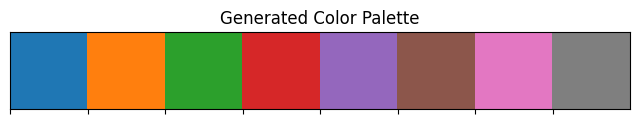

Color 1: #1f77b4
Color 2: #ff7f0e
Color 3: #2ca02c
Color 4: #d62728
Color 5: #9467bd
Color 6: #8c564b
Color 7: #e377c2
Color 8: #7f7f7f


In [14]:
n_groups = len(prominent_cortical_subclasses)
colors = generate_color_palette(palette_type=None, n_colors=n_groups)

display_color_palette(colors)
for i, color in enumerate(colors):
    print(f"Color {i+1}: {color}")

ct_to_color_v1 = {}
for cell_type, color in zip(prominent_cortical_subclasses, colors):
    ct_to_color_v1[cell_type] = color

A basic test is to compare the match rate between subclasses. We observe a higher rate of VT matching between the L5 ET and L6 CT cells compared to all other types. For interpretation, we can normalize to the rate of the glial cells, known not to form long range projections.

/tmp/ipykernel_7038/3226552336.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cell_type_col, y="norm_proj_rate",
/tmp/ipykernel_7038/3226552336.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)


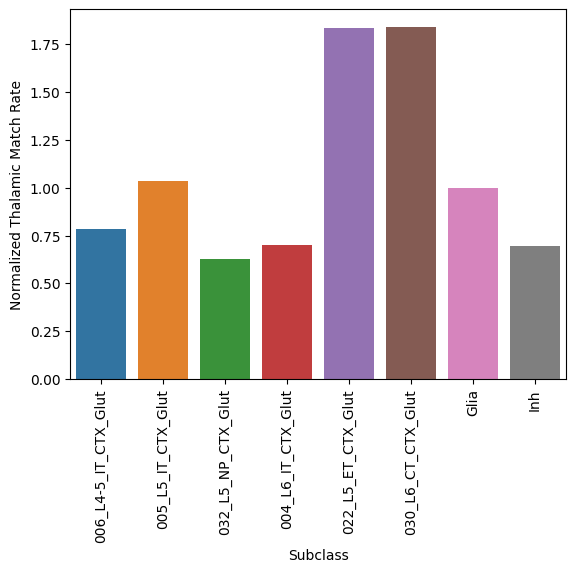

In [15]:
th_vts = v1_grouped_projs["TH"]
v1_vt_cort_df["matches_thalamus"] = v1_vt_cort_df["vt"].isin(th_vts)
cort_thal_match_rates = v1_vt_cort_df.groupby("subclass")["matches_thalamus"].mean().reset_index()
plot_projection_rate_normalized(cort_thal_match_rates, prominent_cortical_subclasses, ct_to_color_v1, ax=None, fig=None)


We also know that not all barcode matches are created equally. Certain sequences appear more prominently in the library of VTs and are thus more likely to be part of "collisions" or cases where multiple cells are transduced with the same barcode.

This information is stored in the "n_observances" column of the VT dataframe, referring to the number of times a certain VT barcode sequence was seen in the pool. We can compare the distributions of this metric and observe that matches of true projections are more likely to come from VTs which are rarer orwere observed less frequently in the pool.


004_L6_IT_CTX_Glut
005_L5_IT_CTX_Glut
006_L4-5_IT_CTX_Glut
022_L5_ET_CTX_Glut
030_L6_CT_CTX_Glut
Glia
Inh


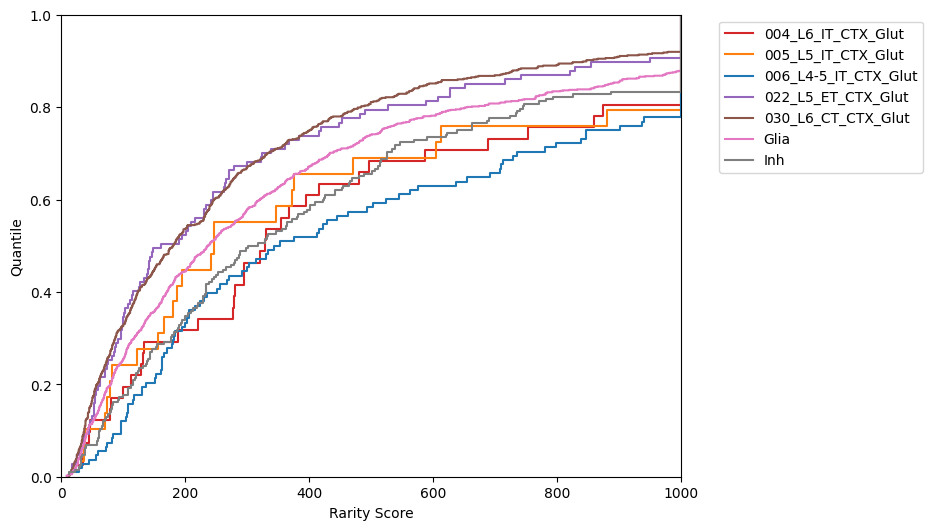

In [17]:
thalamic_matching_df = v1_vt_cort_df.loc[v1_vt_cort_df["matches_thalamus"]]
min_n = 20
matches_per_group = thalamic_matching_df["subclass"].value_counts().reset_index()
valid_groups = matches_per_group.loc[matches_per_group["count"] > min_n, "subclass"].values
thalamic_matching_df = thalamic_matching_df.loc[thalamic_matching_df["subclass"].isin(valid_groups)]

vt_rarity_dist_per_cell = thalamic_matching_df.groupby("subclass")["n_observances"].apply(list)

fig, ax = plt.subplots(figsize=(8,6))
plot_truncated_ecdf(vt_rarity_dist_per_cell, ct_to_color_v1, max_val=1000,ax=ax)
fig.show()


To create a comprehensive model, we incorporated features such as barcode rarity alongside the proportion of background in the cell, found in the "prob_background" column, to create a weighted score to evaluate projection strength.

This score is found in the "prob_attr" column of the dataframe and attempts to estimate the probability that, if a match is observed for that VT in this cell, it is actually the result of a projection from this specific cell.

To make this comparison statistically rigorous, we compare the weighted score to that of the glial cells. Using the glial cells as a null distribution, we assess how unlikely it is to observe matches at this strength if the cell type is not forming projections to a certain region.

To illustrate this we can again examine our thalamic projections.

In [18]:


v1_proj_dists_obj = preform_all_celltype_region_comparisons_jackknife(v1_vt_cort_df, {"Thalamus": th_vts}, score_col = "prob_attr", cell_type_col = "subclass", min_ct_n = 50, null_type="Glia", jackknife_holdout_prop=0.1, return_unparsed=True)
proj_parsed_obj_v1 = parse_cell_type_proj_dists(v1_proj_dists_obj)
min_n = 30


0.0
7
0


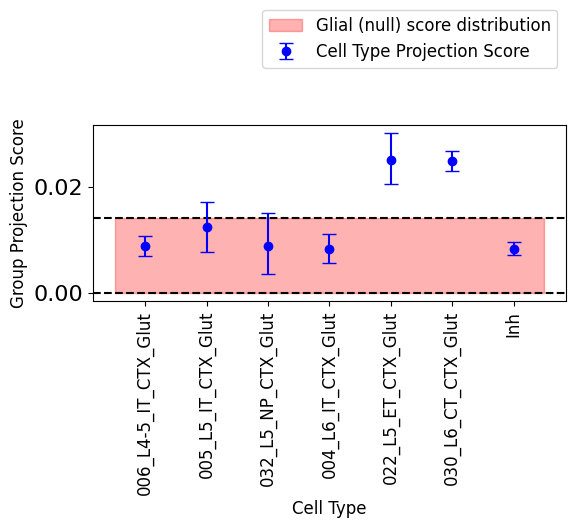

In [19]:
v1_cell_types_subclass_non_glia = [ele for ele in prominent_cortical_subclasses if ele != "Glia"]

fig, ax = plt.subplots(figsize=(6, 9))
plot_cell_type_region_enrich(proj_parsed_obj_v1, region="Thalamus", cell_types_specific=v1_cell_types_subclass_non_glia, title="Thalamus Projection Scores", ax=ax)
fig.show()


We can now utilize this same approach to characterize projections patterns of all cell types across surveyed brain regions.

In [20]:
NBOOT=1000
v1_subclass_projs =  preform_all_celltype_region_comparisons_jackknife(v1_vt_cort_df, v1_grouped_projs, score_col = "prob_attr", cell_type_col = "subclass_visual", min_ct_n = 200, null_type="Glia", jackknife_holdout_prop=0.1, NBOOT=NBOOT)


0.0
35
0
Parsing jacknife results
0.0


In [21]:
v1_cell_to_proj_df = compute_cell_to_region_match_df(v1_vt_cort_df, v1_grouped_projs, cell_type_col="subclass_visual")
v1_cell_to_proj_df["celltype_region"] = v1_cell_to_proj_df["cell_type"] + "_" + v1_cell_to_proj_df["region"]


In [22]:
p_thresh=0.05
v1_subclass_projs["celltype_region"] = v1_subclass_projs["cell_type"] + "_" + v1_subclass_projs["region"]

v1_cell_w_sig_df = pd.merge(v1_cell_to_proj_df, v1_subclass_projs, on="celltype_region", how="inner", suffixes=("_w_n", None))
cell_type_to_n_matched = v1_cell_w_sig_df.groupby("cell_type").apply(lambda group_df: group_df.loc[group_df["jack_p_val"] < 0.05, "cell_id"].nunique())
n_cells_matched_anywhere_v1 = v1_cell_w_sig_df.loc[v1_cell_w_sig_df["jack_p_val"] < p_thresh, "cell_id"].nunique()

subclass_visual_cell_match_rates_dict_v1 = create_type_to_region_prop_cell_match(v1_vt_cort_df, proj_regions=v1_grouped_projs, cell_type_col="subclass_visual")


VISPc
13359
CP
1648
PG
945
SC
6917
TH
23253


/tmp/ipykernel_7038/3226552336.py:666: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'vmin' will be ignored
  ax.scatter(col_inx, row_inx, c=current_color_val, s = pt_size, cmap="Blues", vmin=color_scale_min, vmax=color_scale_max)


<Figure size 2560x1920 with 0 Axes>

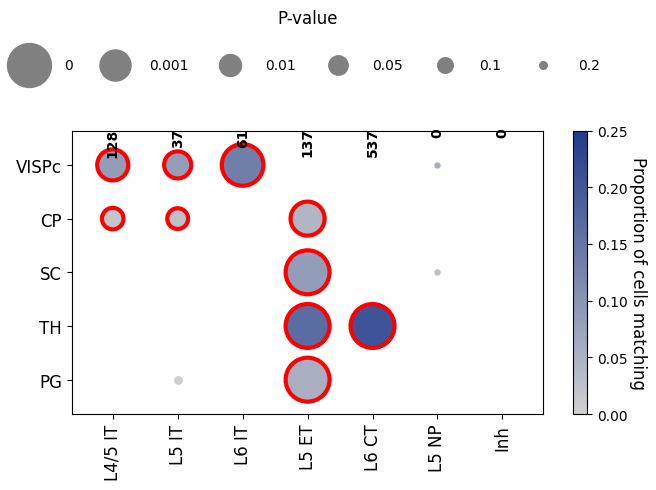

In [23]:
region_ordering_v1 = ["PG", "TH", "SC", "CP", "VISPc"]
cell_type_ordering_v1 = ["L4/5 IT", "L5 IT", "L6 IT", "L5 ET", "L6 CT",  "L5 NP", "Inh"]


create_basic_dotplot_proj_sub_groupings_continous(v1_subclass_projs, 
                            cell_type_col="cell_type",
                            region_col="region",
                            color_col = "prop_vts",
                            text_col="jack_p_val",
                            value_col="jack_p_val",
                            sig_val = 0.05,
                            negate_sig_val=True, only_show_text_if_sig=False,
                            only_show_projecting_cts=False,
                            title="",
                            size_scale =1, show_text=False,
                            space_per_ct=1, space_per_region=1.1,
                            region_ordering=region_ordering_v1,
                            cell_type_ordering=cell_type_ordering_v1,
                            sizing_factor_y=0.1,
                            sizing_factor_x=0.05,
                            sig_circle_width=3,
                            cell_match_rates_dict = subclass_visual_cell_match_rates_dict_v1,
                                                  vmax=0.25,
                            total_intersects_by_ct=cell_type_to_n_matched
                           )


Number of cells projecting to a region at which that cell type reachs signifcance is shown at the top of each column.

Using this approach, we are able to resolve an accurate recapitulation of known cortical projection patterns. IT types project within the telencephalon (contralateral VISp and CP). Our ET cells project diversely across the brain, and L6 CT cells project specifically to the thalamus. We also include known negative controls: L5 NP and Inh types do not form long-range projections.
